# Imports

**NOTE** This runs on `thesis_env` environment

In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime
import json

In [2]:
# gfx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# maps
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

# Import Data

Data is being pulled automatically from RKStudio server and then saved to `3_3_2_processed_data` folder.


**PROCESS**
1. `launchd` runs the `.plist` file `/Library/LaunchAgents/thesis.djw.pull-rkstudio-data.plist` every day at 10:40am
2. `thesis.djw.pull-rkstudio-data.plist` runs `.sh` script `/download/download_rkstudio_data.sh`
3. `download_rkstudio_data.sh` runs `.py` script `/download/download_rkstudio_data.py`
4. `download_rkstudio_data.py` downloads any **new** files from RK Studio, and saves to `.pkl` in `3_3_2_processed_data` folder.

---

**Note:** 
- The `create_dict_df()` function in `download_rkstudio_data.py` is inefficient as it recreates the file from scratch each time it runs instead of just appending new data. If things get slow this could be a spot to address.
- The `create_dict_df()` function is also simply replacing previous file with current file

In [3]:
save_path = "/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/"

in_file = open(save_path + "app_data.pkl", "rb")
app_data = pickle.load(in_file)



## Get size

In [4]:
import sys
import inspect

def get_size(obj, seen=None):
    """Recursively finds size of objects in bytes"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if hasattr(obj, '__dict__'):
        for cls in obj.__class__.__mro__:
            if '__dict__' in cls.__dict__:
                d = cls.__dict__['__dict__']
                if inspect.isgetsetdescriptor(d) or inspect.ismemberdescriptor(d):
                    size += get_size(obj.__dict__, seen)
                break
    if isinstance(obj, dict):
        size += sum((get_size(v, seen) for v in obj.values()))
        size += sum((get_size(k, seen) for k in obj.keys()))
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum((get_size(i, seen) for i in obj))
        
    if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
        size += sum(get_size(getattr(obj, s), seen) for s in obj.__slots__ if hasattr(obj, s))
        
    return size


In [5]:
# get size in GB
get_size(app_data) / 1e9

3.458835007

# Data Clean

## Note

- Feature columns were changed on **March 9, 2021**
- They were changed again on Sept 15
- More tweaks Oct 18
- Added BART task(s) week of Oct 18-22

---

**DateTime** is in [ISO 8601 format](https://en.wikipedia.org/wiki/ISO_8601)
- e.g. `2021-03-05T13:53:52+00:00`
- the +/- offset refers to `UTC`
- but the time is CORRECT for local time
- looks like it was originally created using:

```
# UTC to ISO 8601 with Local TimeZone information without microsecond (Python 3):

import datetime
datetime.datetime.now().astimezone().replace(microsecond=0).isoformat()
>>> 2020-03-20T14:31:43+13:00
```
---

**File Names** are:

In [5]:
list(app_data.keys())

['SurveyTasks',
 'SurveyResults',
 'SurveyStepResults',
 'SurveyQuestionResults',
 'SurveyConsentSignatureResults',
 'SurveyStroopResults',
 'SurveyPSATResults',
 'SurveyTrailmakingResults',
 'SurveyTowerOfHanoiResults',
 'SurveyReactionTimeResults',
 'SurveySpatialSpanMemoryResults',
 'StudyParticipants',
 'HealthKitSamples',
 'HealthKitCharacteristics',
 'HealthKitActivitySummaries',
 'AppleLocationVisits',
 'Manifest']

# Tasks

## Trail Making

[RKStudio Documentation](https://rkstudio-support.careevolution.com/hc/en-us/articles/1500002201361-Trailmaking-Active-Task-Export-Format)

What is trailmaking task really measuring?

>The Trail Making Test is a neuropsychological test of visual attention and task switching. It consists of two parts in which the subject is instructed to connect a set of 25 dots as quickly as possible while still maintaining accuracy. The test can provide information about visual search speed, scanning, speed of processing, mental flexibility, as well as executive functioning.[[1](https://doi.apa.org/doiLanding?doi=10.1037%2F1040-3590.7.2.220)]

Note that we are not doin the 2-part test which seems fairly common. We are doing a version that is mostl like the the typical *Version B*.

- visual attention
- task switching
- fluid intelligence/cognitive abilities

**Reference**
- [Salthouse, 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3141679/)


In [6]:
# select hk_trail data
df = app_data['SurveyTrailmakingResults']
df.head(2)

,SurveyTrailmakingResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,NumberOfErrors,StartDate,EndDate,Taps
0,2a8183c4-4574-ec11-aab6-0afb9334277d,168183c4-4574-ec11-aab6-0afb9334277d,0b8183c4-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,0,2022-01-13T02:52:22-05:00,2022-01-13T02:52:38-05:00,"[{""TapTimestamp"":1.313567042350769,""TapIndex"":..."
1,32aa5fd1-4574-ec11-aab6-0afb9334277d,22aa5fd1-4574-ec11-aab6-0afb9334277d,17aa5fd1-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,0,2022-01-13T02:52:49-05:00,2022-01-13T02:53:02-05:00,"[{""TapTimestamp"":2.6853829622268677,""TapIndex""..."


Need to get the `ActualDueDate`

This is a bit of an edge case, as it just applies to people who did their task after midnight, but we want to make sure each task is associated with the correct day.

For example, if you did the **Trailmaking** task at 1:15, you don't actually want it to be associated with the current day's data, as for our purposes the day of interest continues until the subject goes to sleep, so we would want to subtract a day from the date.

Note that the tasks expire at 5am, which is whey we select for `hour < 5`

In [7]:
# Add date column
df['ActualDueDate'] = 0

# Faster way than loop to do this?
for i in range(len(df.EndDate)):

    if pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 5:
        # subtract one day from date
        df['ActualDueDate'][i] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        df['ActualDueDate'][i] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

<ipython-input-7-9edfca1f66ce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ActualDueDate'][i] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
<ipython-input-7-9edfca1f66ce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ActualDueDate'][i] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()


In [8]:
df.head(2)

,SurveyTrailmakingResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,NumberOfErrors,StartDate,EndDate,Taps,ActualDueDate
0,2a8183c4-4574-ec11-aab6-0afb9334277d,168183c4-4574-ec11-aab6-0afb9334277d,0b8183c4-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,0,2022-01-13T02:52:22-05:00,2022-01-13T02:52:38-05:00,"[{""TapTimestamp"":1.313567042350769,""TapIndex"":...",2022-01-12
1,32aa5fd1-4574-ec11-aab6-0afb9334277d,22aa5fd1-4574-ec11-aab6-0afb9334277d,17aa5fd1-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,0,2022-01-13T02:52:49-05:00,2022-01-13T02:53:02-05:00,"[{""TapTimestamp"":2.6853829622268677,""TapIndex""...",2022-01-12


The important data is in `Taps` where we have:
- `TapTimestamp`
- `TapIndex`
- `TapIncorrect`

I want to get the last `TapTimestamp` to calculate total timing

In [9]:
# Taps is a string of a list of dictionaries
df.Taps[0]

'[{"TapTimestamp":1.313567042350769,"TapIndex":0,"TapIncorrect":false},{"TapTimestamp":6.093487024307251,"TapIndex":1,"TapIncorrect":false},{"TapTimestamp":8.166045069694519,"TapIndex":2,"TapIncorrect":false},{"TapTimestamp":9.0185450315475464,"TapIndex":3,"TapIncorrect":false},{"TapTimestamp":9.70399808883667,"TapIndex":4,"TapIncorrect":false},{"TapTimestamp":9.9209880828857422,"TapIndex":5,"TapIncorrect":false},{"TapTimestamp":10.1891371011734,"TapIndex":6,"TapIncorrect":false},{"TapTimestamp":10.8576180934906,"TapIndex":7,"TapIncorrect":false},{"TapTimestamp":11.408498048782349,"TapIndex":8,"TapIncorrect":false},{"TapTimestamp":12.378225088119507,"TapIndex":9,"TapIncorrect":false},{"TapTimestamp":12.896679043769836,"TapIndex":10,"TapIncorrect":false},{"TapTimestamp":13.130498051643372,"TapIndex":11,"TapIncorrect":false},{"TapTimestamp":14.233527064323425,"TapIndex":12,"TapIncorrect":false}]'

In [10]:
# Can convert to list of dicts and then access an individual dict
data = json.loads(df.Taps[0])
print(data[-1])
data[-1]['TapTimestamp']

{'TapTimestamp': 14.233527064323425, 'TapIndex': 12, 'TapIncorrect': False}


14.233527064323425

In [11]:
# convert string Taps to list of dicts
df['TapsList'] = df['Taps'].apply(json.loads)

# assign new columns with final value from TapsList
# rename column
df = df.assign(Task_Trailmaking_Time=lambda x: x.TapsList.apply(lambda x: x[-1]['TapTimestamp']),
               Task_Trailmaking_Errors=lambda x: x.NumberOfErrors)

# keep relevant columns
df = df[['ParticipantIdentifier', 'ActualDueDate', 'Task_Trailmaking_Time', 'Task_Trailmaking_Errors']]
df.head(2)

,ParticipantIdentifier,ActualDueDate,Task_Trailmaking_Time,Task_Trailmaking_Errors
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,14.233527,0
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,11.025836,0


### Plot

In [12]:
# get dates ordered so plot isn't weird
df.sort_values(by=['ActualDueDate'], inplace=True)

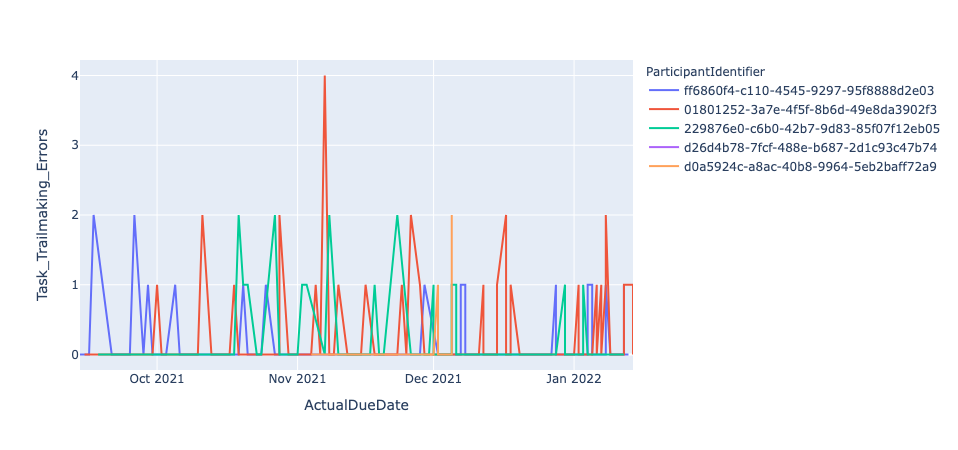

In [15]:
fig = px.line(df, x="ActualDueDate", y="Task_Trailmaking_Errors", color='ParticipantIdentifier')
fig.show()

In [16]:
df.groupby(['ParticipantIdentifier'])['Task_Trailmaking_Time'].mean()

ParticipantIdentifier
01801252-3a7e-4f5f-8b6d-49e8da3902f3    10.589112
229876e0-c6b0-42b7-9d83-85f07f12eb05     8.293525
d0a5924c-a8ac-40b8-9964-5eb2baff72a9    14.892433
d26d4b78-7fcf-488e-b687-2d1c93c47b74     7.280845
ff6860f4-c110-4545-9297-95f8888d2e03     8.087498
Name: Task_Trailmaking_Time, dtype: float64

### Join

In [17]:
# create master df_tasks, as df will be reassigned
df_tasks = df

## Stroop

[Scarpina & Tagini, 2017](https://www.frontiersin.org/articles/10.3389/fpsyg.2017.00557/full) on scoring in their paper The Stroop Color and Words Test.

>The Stroop Color and Word Test (SCWT) is a neuropsychological test extensively used to assess the ability to inhibit cognitive interference that occurs when the processing of a specific stimulus feature impedes the simultaneous processing of a second stimulus attribute, well-known as the Stroop Effect.

**Interpretation**
>While the SCWT is widelyused to measure the ability to inhibit cognitive interference; previous literature also reports itsapplication to measure other cognitive functions such as attention, processing speed, cognitive flexibility (Jensen and Rohwer, 1966), and working memory(Kane and Engle, 2003). Thus, it may be possible to use the SCWTto measure multiple cognitive functions.

>According to the review, the studies with Italian normativedata present different theoretical interpretations of the SCWTscores.Amato et al. (2006)andCaffarra et al. (2002)describe theSCWT score as a measure of the fronto-executive functioning,while others use it as an index of the attentional functioning(Barbarotto et al., 1998; Valgimigli et al., 2010) or of generalcognitive efficiency (Brugnolo et al., 2015). Slowing to a responseconflict would be due to a failure of selective attention or a lack inthe cognitive efficiency instead of a failure of response inhibition(Chafetz and Matthews, 2004); however, the performance inthe SCWT is not exclusively related to concentration, attentionor cognitive effectiveness, but it relies to a more specificexecutive-frontal domain. Indeed, subjects have to processselectively a specific visual feature blocking out continuouslythe automatic processing of reading (Zajano and Gorman, 1986;Shum et al., 1990), in order to solve correctly the task. The specificinvolvement of executive processes is supported by clinical data.Patients with anterior frontal lesions, and not with posteriorcerebral damages, report significant difficulties in maintaining aconsistent activation of the intended response (Valgimigli et al.,2010). Furthermore, Parkinson’s Disease patients, characterizedby executive dysfunction due to the disruption of dopaminergicpathway (Fera et al., 2007), reported difficulties in SCWT despiteunimpaired attentional abilities (Fera et al., 2007; Djamshidianet al., 2011).

In [23]:
df = app_data['SurveyStroopResults']
df.head(2)

,SurveyStroopResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,StartTime,EndTime,ColorSelected,Color,Text,StroopStyle,StartDate,EndDate,ActualDueDate
0,c749c49e-4574-ec11-aab6-0afb9334277d,b749c49e-4574-ec11-aab6-0afb9334277d,ac49c49e-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,322874.165475,322875.254130,RED,RED,GREEN,NaN,2022-01-13T02:51:14-05:00,2022-01-13T02:51:14-05:00,2022-01-12
1,c849c49e-4574-ec11-aab6-0afb9334277d,b749c49e-4574-ec11-aab6-0afb9334277d,ac49c49e-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,322875.756635,322876.557284,YELLOW,YELLOW,RED,NaN,2022-01-13T02:51:15-05:00,2022-01-13T02:51:15-05:00,2022-01-12


Need to get the `ActualDueDate`

This is a bit of an edge case, as it just applies to people who did their task after midnight, but we want to make sure each task is associated with the correct day.

For example, if you did the **Trailmaking** task at 1:15, you don't actually want it to be associated with the current day's data, as for our purposes the day of interest continues until the subject goes to sleep, so we would want to subtract a day from the date.

Note that the tasks expire at 4am, which is whey we select for `hour < 4`

In [24]:
# Add date column
df['ActualDueDate'] = 0

# Faster way than loop to do this?
for i in range(len(df.EndDate)):

    if pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 4:
        # subtract one day from date
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

In [25]:
# create correct, congruous and time columns
df = df[['ParticipantIdentifier', 'ActualDueDate', 'StartTime', 'EndTime', 'ColorSelected', 'Color', 'Text']]
df = df.assign(Congruent=lambda x: x.Color == x.Text,
               Correct=lambda x: x.Color == x.ColorSelected,
               Time=lambda x: (x.EndTime - x.StartTime)
              )
df.head(3)

,ParticipantIdentifier,ActualDueDate,StartTime,EndTime,ColorSelected,Color,Text,Congruent,Correct,Time
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,322874.165475,322875.254130,RED,RED,GREEN,False,True,1.088655
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,322875.756635,322876.557284,YELLOW,YELLOW,RED,False,True,0.800649
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,322877.059443,322877.810955,BLUE,BLUE,BLUE,True,True,0.751512


In [26]:
# should I also have columns like congruent correct rt, congruent incorrect rt, etc...

# define function that returns a Series of all aggregations

def f(x):
    d = {}
    
    d['Task_Stroop_TotalCorrectProp'] = x['Correct'].sum()/len(x['Correct'])
    d['Task_Stroop_CongruentCorrectProp'] = len(x.loc[(x.Congruent==True) & (x.Correct==True)])/x.Congruent.value_counts()[1]
    d['Task_Stroop_IncongruentCorrectProp'] = len(x.loc[(x.Congruent==False) & (x.Correct==True)])/x.Congruent.value_counts()[0]
    d['Task_Stroop_TotalAvgRT'] = x['Time'].sum()/len(x['Time'])    
    d['Task_Stroop_CongruentAvgRT'] = x.loc[x.Congruent==True,'Time'].sum()/x.Congruent.value_counts()[1]    
    d['Task_Stroop_IncongruentAvgRT'] = x.loc[x.Congruent==False,'Time'].sum()/x.Congruent.value_counts()[0]
    
    return pd.Series(d, index=['Task_Stroop_TotalCorrectProp', 'Task_Stroop_CongruentCorrectProp',
                               'Task_Stroop_IncongruentCorrectProp', 'Task_Stroop_TotalAvgRT',
                               'Task_Stroop_CongruentAvgRT', 'Task_Stroop_IncongruentAvgRT'
                              ])

# note that value_counts gives us the number of trues and falses for boolean columns
# then indexing into 0 for false and 1 for true

In [27]:
df = df.groupby(['ActualDueDate', 'ParticipantIdentifier']).apply(f).reset_index()
df.head(3)

,ActualDueDate,ParticipantIdentifier,Task_Stroop_TotalCorrectProp,Task_Stroop_CongruentCorrectProp,Task_Stroop_IncongruentCorrectProp,Task_Stroop_TotalAvgRT,Task_Stroop_CongruentAvgRT,Task_Stroop_IncongruentAvgRT
0,2021-09-14,ff6860f4-c110-4545-9297-95f8888d2e03,0.90,1.000000,0.777778,0.628864,0.563768,0.708425
1,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,0.95,0.928571,1.000000,1.025785,1.052757,0.962850
2,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,0.85,0.875000,0.833333,0.747848,0.744538,0.750055


### Plot

In [28]:
df.mean()

Task_Stroop_TotalCorrectProp          0.976614
Task_Stroop_CongruentCorrectProp      0.982571
Task_Stroop_IncongruentCorrectProp    0.971089
Task_Stroop_TotalAvgRT                0.722291
Task_Stroop_CongruentAvgRT            0.688877
Task_Stroop_IncongruentAvgRT          0.756348
dtype: float64

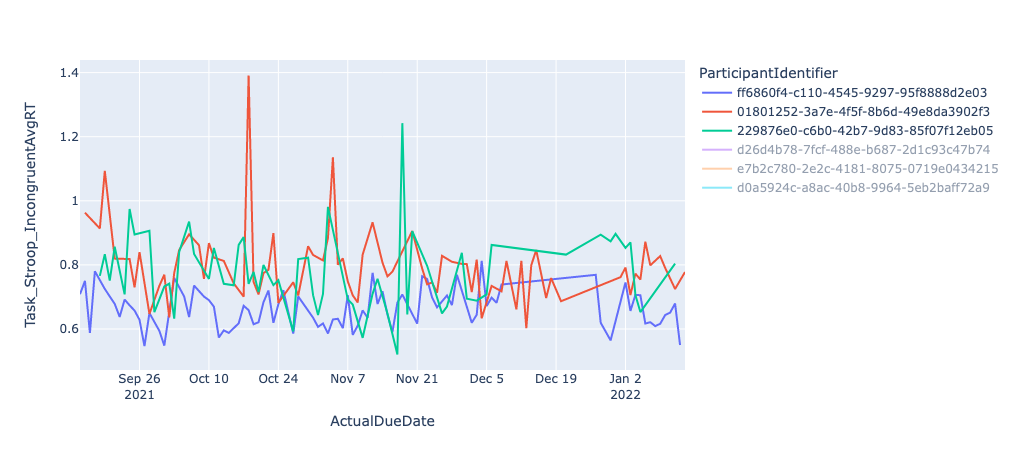

In [29]:
fig = px.line(df, x="ActualDueDate", y="Task_Stroop_IncongruentAvgRT", color='ParticipantIdentifier')
fig.show()

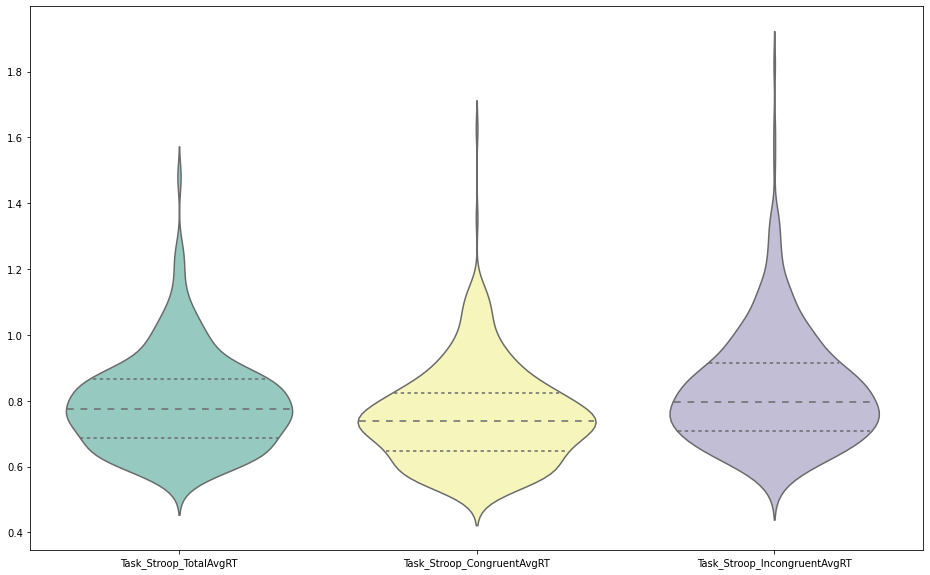

In [24]:
plt.figure(figsize=(16, 10))
sns.violinplot(data=df.loc[:,'Task_Stroop_TotalAvgRT':],
               inner="quartile", palette="Set3")

### Join

In [30]:
# join
df_tasks = df_tasks.merge(df, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df_tasks.head(3)

,ParticipantIdentifier,ActualDueDate,Task_Trailmaking_Time,Task_Trailmaking_Errors,Task_Stroop_TotalCorrectProp,Task_Stroop_CongruentCorrectProp,Task_Stroop_IncongruentCorrectProp,Task_Stroop_TotalAvgRT,Task_Stroop_CongruentAvgRT,Task_Stroop_IncongruentAvgRT
0,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-14,9.969619,0,0.90,1.000000,0.777778,0.628864,0.563768,0.708425
1,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-15,8.456242,0,0.85,0.875000,0.833333,0.747848,0.744538,0.750055
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-09-15,6.931486,0,0.95,0.928571,1.000000,1.025785,1.052757,0.962850


## PSAT

[RKStudio Documentation](https://rkstudio-support.careevolution.com/hc/en-us/articles/1500002352262-Paced-Serial-Addition-Test-PSAT-Active-Task-Export-Format)

In [31]:
df = app_data['SurveyPSATResults']

In [32]:
df.head(2)

,SurveyPSATResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,PresentationMode,InterStimulusInterval,StimulusDuration,Length,TotalCorrect,TotalDyad,TotalTime,InitialDigit,StartDate,EndDate,Samples
0,8ac05d27-4674-ec11-aab6-0afb9334277d,7cc05d27-4674-ec11-aab6-0afb9334277d,72c05d27-4674-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,Visual,3,1,30,30,29,38.057122,9,2022-01-13T02:55:18-05:00,2022-01-13T02:55:18-05:00,"[{""Answer"":13,""Correct"":true,""Time"":1.24970900..."
1,efcb64ad-8c74-ec11-aab6-0afb9334277d,e0cb64ad-8c74-ec11-aab6-0afb9334277d,d6cb64ad-8c74-ec11-aab6-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,Visual,3,1,30,29,27,36.962396,9,2022-01-13T11:20:11-05:00,2022-01-13T11:20:11-05:00,"[{""Answer"":14,""Correct"":true,""Time"":1.21793699..."


---

Need to get the `ActualDueDate`

This is a bit of an edge case, as it just applies to people who did their task after midnight, but we want to make sure each task is associated with the correct day.

For example, if you did the **Trailmaking** task at 1:15, you don't actually want it to be associated with the current day's data, as for our purposes the day of interest continues until the subject goes to sleep, so we would want to subtract a day from the date.

Note that the tasks expire at 4am, which is whey we select for `hour < 4`

In [33]:
# Add date column
df['ActualDueDate'] = 0

# Faster way than loop to do this?
for i in range(len(df.EndDate)):

    if pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 4:
        # subtract one day from date
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

---

The important data is:
- `Length` + `TotalCorrect` to determine accuracy
- `TotalTime` / `Length` to get time/trial 
    - (use this instead of `TotalTime` in case we change number of trials

In [34]:
# assign new column with accuracy value
df = df.assign(Task_PSAT_Accuracy=lambda x: x.TotalCorrect/x.Length,
               Task_PSAT_AvgTime=lambda x: x.TotalTime/x.Length
              )

# keep relevant columns
df = df[['ParticipantIdentifier', 'ActualDueDate', 'Task_PSAT_Accuracy', 'Task_PSAT_AvgTime']]
df.head(2)

,ParticipantIdentifier,ActualDueDate,Task_PSAT_Accuracy,Task_PSAT_AvgTime
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,1.000000,1.268571
1,ff6860f4-c110-4545-9297-95f8888d2e03,2022-01-13,0.966667,1.232080


### Plot

In [35]:
# get dates ordered so plot isn't weird
df.sort_values(by=['ActualDueDate'], inplace=True)

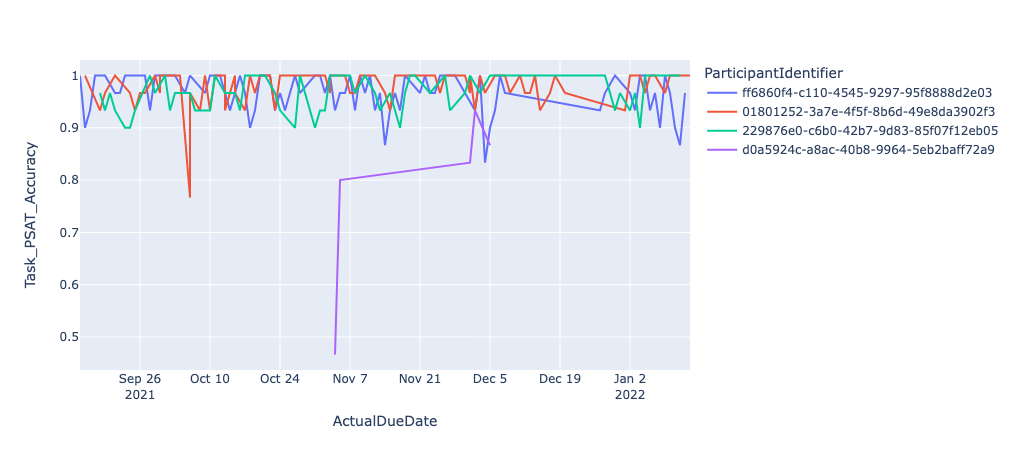

In [36]:
fig = px.line(df, x="ActualDueDate", y="Task_PSAT_Accuracy", color='ParticipantIdentifier')
fig.show()

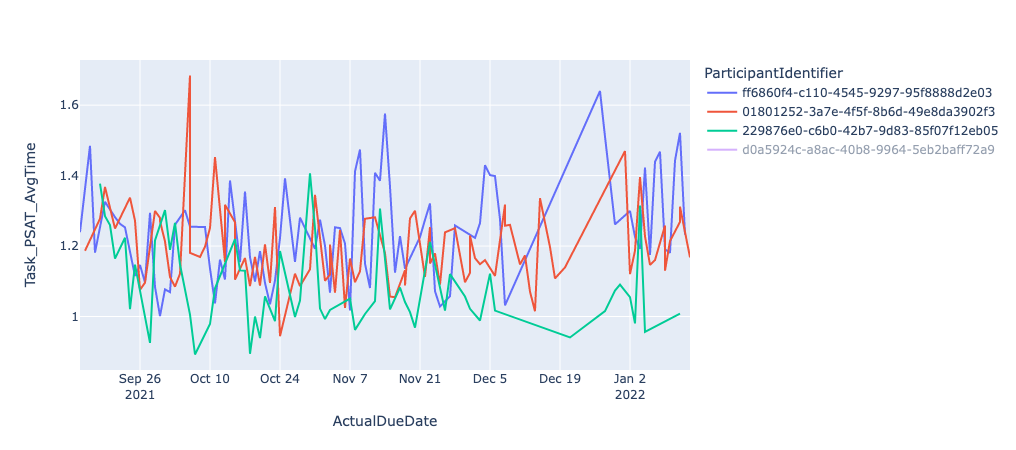

In [37]:
fig = px.line(df, x="ActualDueDate", y="Task_PSAT_AvgTime", color='ParticipantIdentifier')
fig.show()

### Join

In [38]:
# join
df_tasks = df_tasks.merge(df, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df_tasks.head(3)

,ParticipantIdentifier,ActualDueDate,Task_Trailmaking_Time,Task_Trailmaking_Errors,Task_Stroop_TotalCorrectProp,Task_Stroop_CongruentCorrectProp,Task_Stroop_IncongruentCorrectProp,Task_Stroop_TotalAvgRT,Task_Stroop_CongruentAvgRT,Task_Stroop_IncongruentAvgRT,Task_PSAT_Accuracy,Task_PSAT_AvgTime
0,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-14,9.969619,0,0.90,1.000000,0.777778,0.628864,0.563768,0.708425,1.0,1.239531
1,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-15,8.456242,0,0.85,0.875000,0.833333,0.747848,0.744538,0.750055,0.9,1.364448
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-09-15,6.931486,0,0.95,0.928571,1.000000,1.025785,1.052757,0.962850,1.0,1.186668


## Tower of Hanoi

In [39]:
# Details about task

In [40]:
df = app_data['SurveyTowerOfHanoiResults']

In [41]:
df.head(2)

,SurveyTowerOfHanoiResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,PuzzleWasSolved,StartDate,EndDate,Moves
0,04fc22b1-4574-ec11-aab6-0afb9334277d,f8fb22b1-4574-ec11-aab6-0afb9334277d,effb22b1-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,True,2022-01-13T02:51:50-05:00,2022-01-13T02:52:05-05:00,"[{""Timestamp"":0.0,""DonorTowerIndex"":0,""Recipie..."
1,6ec5d44d-8c74-ec11-aab6-0afb9334277d,53c5d44d-8c74-ec11-aab6-0afb9334277d,44c5d44d-8c74-ec11-aab6-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,True,2022-01-13T11:17:17-05:00,2022-01-13T11:17:30-05:00,"[{""Timestamp"":0.0,""DonorTowerIndex"":0,""Recipie..."


---

Need to get the `ActualDueDate`

This is a bit of an edge case, as it just applies to people who did their task after midnight, but we want to make sure each task is associated with the correct day.

For example, if you did the **Trailmaking** task at 1:15, you don't actually want it to be associated with the current day's data, as for our purposes the day of interest continues until the subject goes to sleep, so we would want to subtract a day from the date.

Note that the tasks expire at 4am, which is whey we select for `hour < 4`

In [42]:
# Add date column
df['ActualDueDate'] = 0

# Faster way than loop to do this?
for i in range(len(df.EndDate)):

    if pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 4:
        # subtract one day from date
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

The important data is in `Moves` where we have:
- `TapTimestamp`
- `TapIndex`
- `TapIncorrect`

I want to get the last `TapTimestamp` to calculate total timing

In [43]:
# Taps is a string of a list of dictionaries
df.Moves[0]

'[{"Timestamp":0.0,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp":0.70223605632781982,"DonorTowerIndex":0,"RecipientTowerIndex":1},{"Timestamp":1.1700689792633057,"DonorTowerIndex":2,"RecipientTowerIndex":1},{"Timestamp":1.6214580535888672,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp":2.05588698387146,"DonorTowerIndex":1,"RecipientTowerIndex":0},{"Timestamp":2.5407180786132812,"DonorTowerIndex":1,"RecipientTowerIndex":2},{"Timestamp":3.02577006816864,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp":3.510235071182251,"DonorTowerIndex":0,"RecipientTowerIndex":1},{"Timestamp":3.894989013671875,"DonorTowerIndex":2,"RecipientTowerIndex":1},{"Timestamp":4.2805160284042358,"DonorTowerIndex":2,"RecipientTowerIndex":0},{"Timestamp":4.6473489999771118,"DonorTowerIndex":1,"RecipientTowerIndex":0},{"Timestamp":5.1651760339736938,"DonorTowerIndex":2,"RecipientTowerIndex":1},{"Timestamp":5.5830930471420288,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp":6.30

In [44]:
# Can convert to list of dicts and then access an individual dict
data = json.loads(df.Moves[0])

# print last dict
print(data[-1])

# extract the time
data[-1]['Timestamp']

{'Timestamp': 15.077764987945557, 'DonorTowerIndex': 0, 'RecipientTowerIndex': 2}


15.077764987945557

In [45]:
# numbmer of moves
len(data)

31

---

The important data is:
- `PuzzleWasSolved`
    - just to indicate completion
- Get total time required
    - `Timestamp` in last dictionary
- Get number of moves
    - 1 dict/move so get count of dicts)

In [46]:
# convert string Taps to list of dicts
df['MovesList'] = df['Moves'].apply(json.loads)

# assign new columns
df = df.assign(Task_Hanoi_Solved=lambda x: x.PuzzleWasSolved,
               Task_Hanoi_Time=lambda x: x.MovesList.apply(lambda x: x[-1]['Timestamp']),
               Task_Hanoi_Moves=[len(moves) for moves in df.MovesList] # maybe give this as a multiple on optimality (ideal = 1)?
              )

# keep relevant columns
df = df[['ParticipantIdentifier', 'ActualDueDate', 'Task_Hanoi_Solved', 'Task_Hanoi_Time', 'Task_Hanoi_Moves']]
df.head(2)

,ParticipantIdentifier,ActualDueDate,Task_Hanoi_Solved,Task_Hanoi_Time,Task_Hanoi_Moves
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,True,15.077765,31
1,ff6860f4-c110-4545-9297-95f8888d2e03,2022-01-13,True,13.188679,31


### Plot

In [47]:
# get dates ordered so plot isn't weird
df.sort_values(by=['ActualDueDate'], inplace=True)

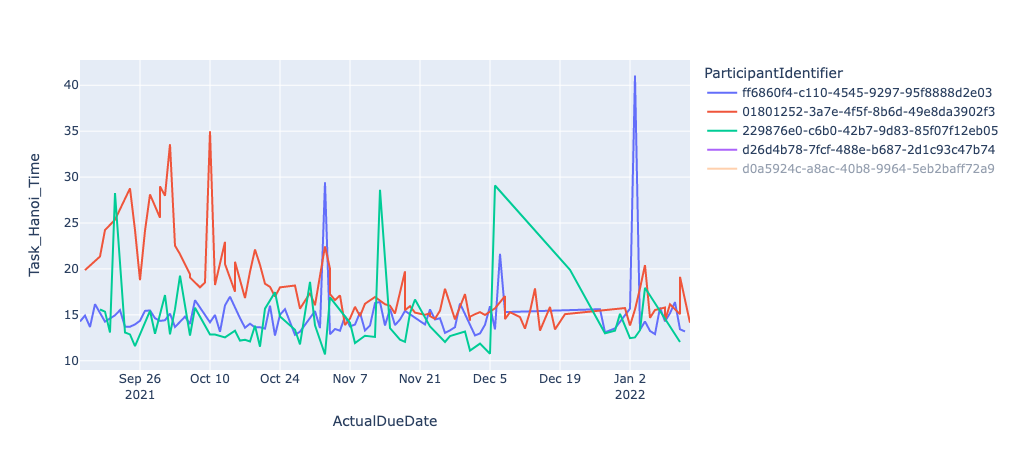

In [48]:
fig = px.line(df, x="ActualDueDate", y="Task_Hanoi_Time", color='ParticipantIdentifier')
fig.show()

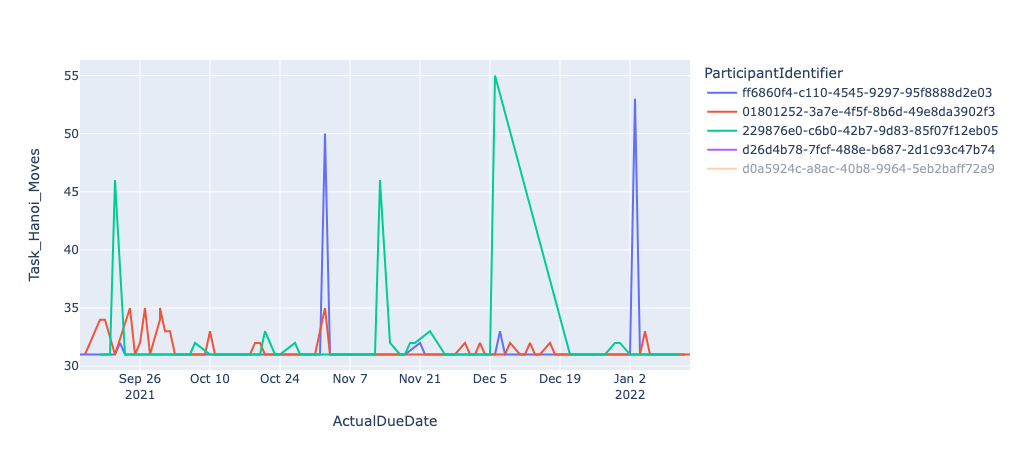

In [49]:
fig = px.line(df, x="ActualDueDate", y="Task_Hanoi_Moves", color='ParticipantIdentifier')
fig.show()

### Join

In [50]:
# join
df_tasks = df_tasks.merge(df, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df_tasks.head(3)

,ParticipantIdentifier,ActualDueDate,Task_Trailmaking_Time,Task_Trailmaking_Errors,Task_Stroop_TotalCorrectProp,Task_Stroop_CongruentCorrectProp,Task_Stroop_IncongruentCorrectProp,Task_Stroop_TotalAvgRT,Task_Stroop_CongruentAvgRT,Task_Stroop_IncongruentAvgRT,Task_PSAT_Accuracy,Task_PSAT_AvgTime,Task_Hanoi_Solved,Task_Hanoi_Time,Task_Hanoi_Moves
0,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-14,9.969619,0,0.90,1.000000,0.777778,0.628864,0.563768,0.708425,1.0,1.239531,True,14.275878,31.0
1,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-15,8.456242,0,0.85,0.875000,0.833333,0.747848,0.744538,0.750055,0.9,1.364448,True,14.924396,31.0
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-09-15,6.931486,0,0.95,0.928571,1.000000,1.025785,1.052757,0.962850,1.0,1.186668,True,19.871385,31.0


## Reaction Time

In [51]:
# Add info on task

In [52]:
df = app_data['SurveyReactionTimeResults']

In [53]:
df.head(5)

,SurveyReactionTimeResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,ReactionTime,StartDate,EndDate
0,4814938c-4574-ec11-aab6-0afb9334277d,3c14938c-4574-ec11-aab6-0afb9334277d,3314938c-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,322839.117122,2022-01-13T02:50:38-05:00,2022-01-13T02:50:38-05:00
1,4914938c-4574-ec11-aab6-0afb9334277d,3c14938c-4574-ec11-aab6-0afb9334277d,3314938c-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,322846.881326,2022-01-13T02:50:46-05:00,2022-01-13T02:50:46-05:00
2,4a14938c-4574-ec11-aab6-0afb9334277d,3c14938c-4574-ec11-aab6-0afb9334277d,3314938c-4574-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,322858.484351,2022-01-13T02:50:58-05:00,2022-01-13T02:50:58-05:00
3,2aa6032a-8c74-ec11-aab6-0afb9334277d,06a6032a-8c74-ec11-aab6-0afb9334277d,efa5032a-8c74-ec11-aab6-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,758000.597514,2022-01-13T11:16:17-05:00,2022-01-13T11:16:17-05:00
4,2da6032a-8c74-ec11-aab6-0afb9334277d,06a6032a-8c74-ec11-aab6-0afb9334277d,efa5032a-8c74-ec11-aab6-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,758008.210013,2022-01-13T11:16:24-05:00,2022-01-13T11:16:24-05:00


---

Need to get the `ActualDueDate`

This is a bit of an edge case, as it just applies to people who did their task after midnight, but we want to make sure each task is associated with the correct day.

For example, if you did the **Trailmaking** task at 1:15, you don't actually want it to be associated with the current day's data, as for our purposes the day of interest continues until the subject goes to sleep, so we would want to subtract a day from the date.

Note that the tasks expire at 4am, which is whey we select for `hour < 4`

In [54]:
# Add date column
df['ActualDueDate'] = 0

# Faster way than loop to do this?
for i in range(len(df.EndDate)):

    if pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 4:
        # subtract one day from date
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

---
Each RT is a separate line, so will need to groupby date and participant...

The important data is:
- `ReactionTime` 
    - Use this to calculate both **mean** and **standard deviation**

In [55]:
df = pd.DataFrame(df.groupby(['ActualDueDate', 'ParticipantIdentifier'])['ReactionTime'].agg(['mean', 'std'])).reset_index()

# rename columns
df.rename(columns={'mean': 'Task_RT_Mean', 'std': 'Task_RT_SD'}, inplace=True)

df.head(2)

,ActualDueDate,ParticipantIdentifier,Task_RT_Mean,Task_RT_SD
0,2021-09-14,ff6860f4-c110-4545-9297-95f8888d2e03,1.237489e+06,9.562265
1,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,3.456691e+05,9.651065


In [56]:
df.head(10)

,ActualDueDate,ParticipantIdentifier,Task_RT_Mean,Task_RT_SD
0,2021-09-14,ff6860f4-c110-4545-9297-95f8888d2e03,1.237489e+06,9.562265
1,2021-09-15,01801252-3a7e-4f5f-8b6d-49e8da3902f3,3.456691e+05,9.651065
2,2021-09-15,ff6860f4-c110-4545-9297-95f8888d2e03,1.264181e+06,9.477375
3,2021-09-16,ff6860f4-c110-4545-9297-95f8888d2e03,1.287526e+06,9.500023
4,2021-09-17,ff6860f4-c110-4545-9297-95f8888d2e03,1.329716e+06,9.542125
5,2021-09-18,01801252-3a7e-4f5f-8b6d-49e8da3902f3,4.569599e+05,9.627976
6,2021-09-18,229876e0-c6b0-42b7-9d83-85f07f12eb05,2.574272e+04,9.526807
7,2021-09-19,01801252-3a7e-4f5f-8b6d-49e8da3902f3,4.836108e+05,11.013062
8,2021-09-19,229876e0-c6b0-42b7-9d83-85f07f12eb05,5.051256e+04,13.610675
9,2021-09-19,ff6860f4-c110-4545-9297-95f8888d2e03,1.377995e+06,9.483229


### Plot

In [57]:
# get dates ordered so plot isn't weird
df.sort_values(by=['ActualDueDate'], inplace=True)

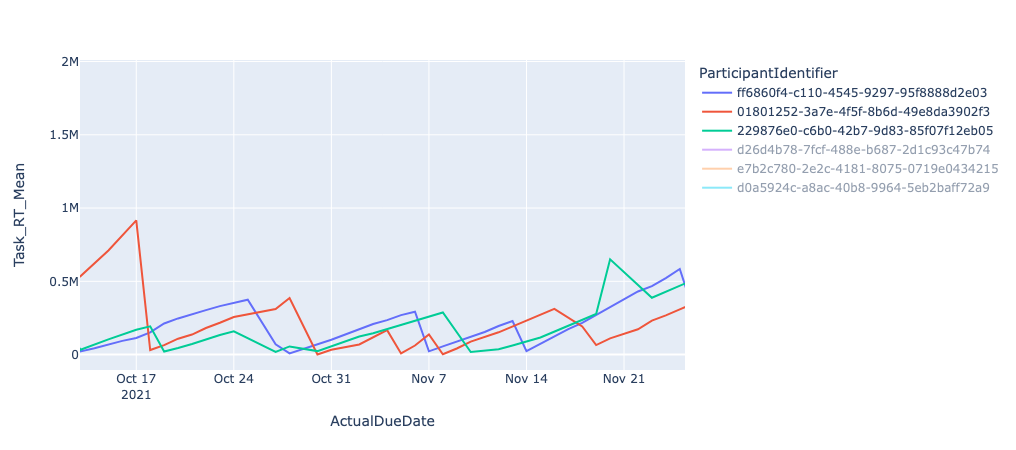

In [58]:
fig = px.line(df, x="ActualDueDate", y="Task_RT_Mean", color='ParticipantIdentifier')
fig.show()

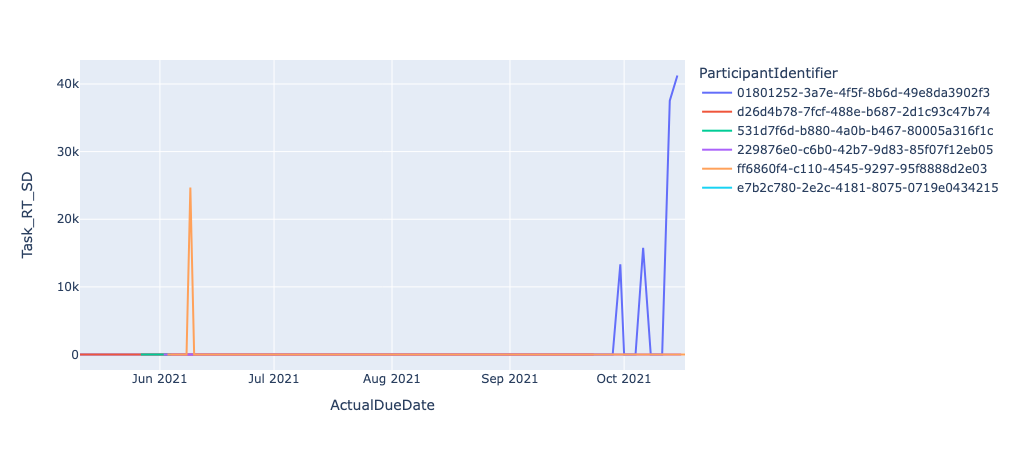

In [53]:
fig = px.line(df, x="ActualDueDate", y="Task_RT_SD", color='ParticipantIdentifier')
fig.show()

### Join

In [59]:
# join
df_tasks = df_tasks.merge(df, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df_tasks.head(3)

,ParticipantIdentifier,ActualDueDate,Task_Trailmaking_Time,Task_Trailmaking_Errors,Task_Stroop_TotalCorrectProp,Task_Stroop_CongruentCorrectProp,Task_Stroop_IncongruentCorrectProp,Task_Stroop_TotalAvgRT,Task_Stroop_CongruentAvgRT,Task_Stroop_IncongruentAvgRT,Task_PSAT_Accuracy,Task_PSAT_AvgTime,Task_Hanoi_Solved,Task_Hanoi_Time,Task_Hanoi_Moves,Task_RT_Mean,Task_RT_SD
0,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-14,9.969619,0,0.90,1.000000,0.777778,0.628864,0.563768,0.708425,1.0,1.239531,True,14.275878,31.0,1.237489e+06,9.562265
1,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-15,8.456242,0,0.85,0.875000,0.833333,0.747848,0.744538,0.750055,0.9,1.364448,True,14.924396,31.0,1.264181e+06,9.477375
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-09-15,6.931486,0,0.95,0.928571,1.000000,1.025785,1.052757,0.962850,1.0,1.186668,True,19.871385,31.0,3.456691e+05,9.651065


## Spatial Span Memory

In [60]:
# Info on measure

In [61]:
df = app_data['SurveySpatialSpanMemoryResults']

In [62]:
df.head(2)

,SurveySpatialSpanMemoryResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,Score,NumberOfGames,NumberOfFailures,StartDate,EndDate,GameRecords
0,19a2876b-4474-ec11-aab6-0afb9334277d,0ca2876b-4474-ec11-aab6-0afb9334277d,03a2876b-4474-ec11-aab6-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,395,6,1,2022-01-13T02:42:04-05:00,2022-01-13T02:43:02-05:00,"[{""Seed"":0,""Sequence"":[6,1,0],""GameSize"":9,""Ga..."
1,cb5c4ed1-8c74-ec11-aab6-0afb9334277d,ba5c4ed1-8c74-ec11-aab6-0afb9334277d,ab5c4ed1-8c74-ec11-aab6-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,540,6,0,2022-01-13T11:20:17-05:00,2022-01-13T11:21:14-05:00,"[{""Seed"":1169281741,""Sequence"":[3,5,6],""GameSi..."


---

Need to get the `ActualDueDate`

This is a bit of an edge case, as it just applies to people who did their task after midnight, but we want to make sure each task is associated with the correct day.

For example, if you did the **Trailmaking** task at 1:15, you don't actually want it to be associated with the current day's data, as for our purposes the day of interest continues until the subject goes to sleep, so we would want to subtract a day from the date.

Note that the tasks expire at 4am, which is whey we select for `hour < 4`

In [63]:
# Add date column
df['ActualDueDate'] = 0

# Faster way than loop to do this?
for i in range(len(df.EndDate)):

    if pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 4:
        # subtract one day from date
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        df.loc[i, 'ActualDueDate'] = pd.to_datetime(df.EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

---

To capture performance we are using:
- `Score` 

**NB** | Might be worth checking out exactly how this is calculated, but for our purposes it seems to be a good proxy of how well you actually do on the task (e.g. you get a better score if you fail on the last attempt (to get 8 in a row) then if you fail on the second attempt and only make it to 6 in a row...)

In [64]:
# assign new column with accuracy value
df = df.assign(Task_SSMemory_Score=lambda x: x.Score
              )

# keep relevant columns
df = df[['ParticipantIdentifier', 'ActualDueDate', 'Task_SSMemory_Score']]
df.head(2)

,ParticipantIdentifier,ActualDueDate,Task_SSMemory_Score
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-01-12,395
1,ff6860f4-c110-4545-9297-95f8888d2e03,2022-01-13,540


### Plot

In [65]:
# get dates ordered so plot isn't weird
df.sort_values(by=['ActualDueDate'], inplace=True)

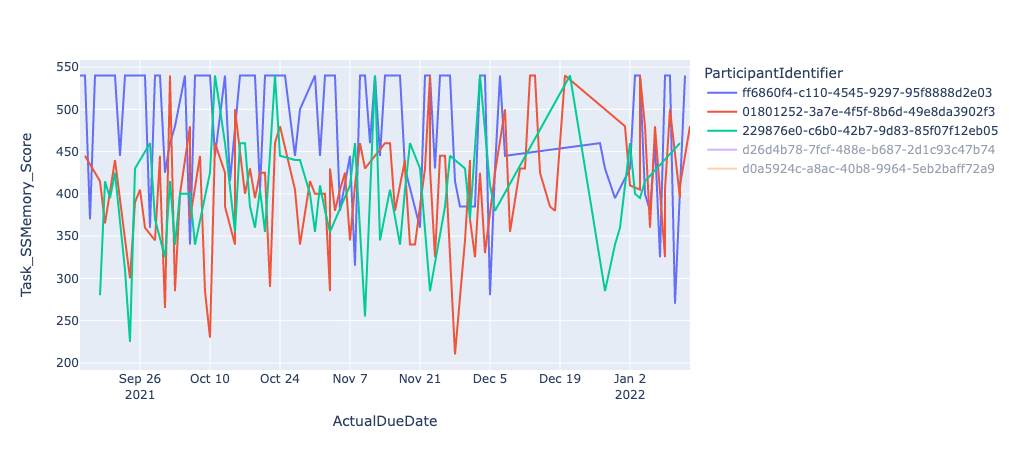

In [66]:
fig = px.line(df, x="ActualDueDate", y="Task_SSMemory_Score", color='ParticipantIdentifier')
fig.show()

### Join

In [67]:
# join
df_tasks = df_tasks.merge(df, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df_tasks.head(3)

,ParticipantIdentifier,ActualDueDate,Task_Trailmaking_Time,Task_Trailmaking_Errors,Task_Stroop_TotalCorrectProp,Task_Stroop_CongruentCorrectProp,Task_Stroop_IncongruentCorrectProp,Task_Stroop_TotalAvgRT,Task_Stroop_CongruentAvgRT,Task_Stroop_IncongruentAvgRT,Task_PSAT_Accuracy,Task_PSAT_AvgTime,Task_Hanoi_Solved,Task_Hanoi_Time,Task_Hanoi_Moves,Task_RT_Mean,Task_RT_SD,Task_SSMemory_Score
0,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-14,9.969619,0,0.90,1.000000,0.777778,0.628864,0.563768,0.708425,1.0,1.239531,True,14.275878,31.0,1.237489e+06,9.562265,540.0
1,ff6860f4-c110-4545-9297-95f8888d2e03,2021-09-15,8.456242,0,0.85,0.875000,0.833333,0.747848,0.744538,0.750055,0.9,1.364448,True,14.924396,31.0,1.264181e+06,9.477375,540.0
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-09-15,6.931486,0,0.95,0.928571,1.000000,1.025785,1.052757,0.962850,1.0,1.186668,True,19.871385,31.0,3.456691e+05,9.651065,445.0


# Export DF

In [63]:
df_tasks.to_csv('data/features/task_features.csv')

# Plot

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
sns.set_theme(style="white")

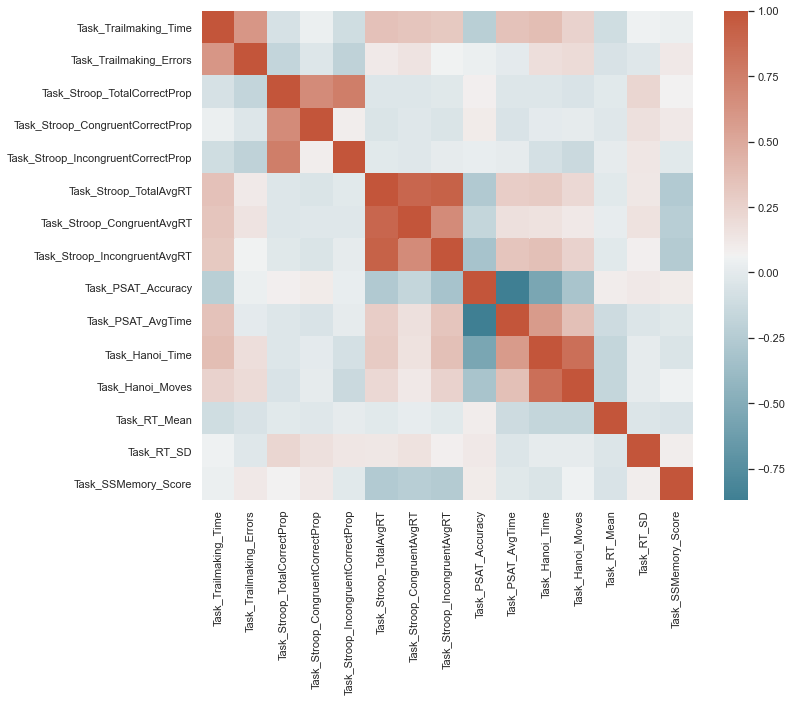

In [66]:
# Compute the correlation matrix
corr = df_tasks.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap)